# Chapter 2: Small Worlds And Large Worlds - Samples

In [68]:
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc as pm

### Code 2.1

Calculate the plausibilities through counts of ways to produce data.

In [33]:
ways = np.array([0, 3, 8, 9, 0])
ways / ways.sum()

array([0.  , 0.15, 0.4 , 0.45, 0.  ])

### Code 2.2

Calculate the likelihood of data.

> The counts of "water" W and "land" L are distributed binomially, with probability p of "water" on each toss.

$$P(w|n,p) = \binom{w}{n}p^w\dot(1-p)^{n-w}$$

In [34]:
stats.binom.pmf(k=6, n=9, p=.5)

0.16406250000000003

### Code 2.3

In the context of the globe tossing problem, grid approximation works extremely well. The recipe:

1. Define the grid. This means you decide how many points to use in estimating the posterior, and then you make a list of the parameter values on the grid.
2. Compute the value of the prior at each parameter value on the grid.
3. Compute the likelihood at each parameter value.
4. Compute the unstandardized posterior at each parameter value, by multiplying the prior by the likelihood.
5. Finally, standardize the posterior, by dividing each value by the sum of all values.

In [77]:
# R.code 2.3

GRID_POINTS = 20

# Define grid.
p_grid = np.linspace(0,1,GRID_POINTS)

# Define prior.
prior = np.repeat(1,GRID_POINTS)

# Compute likelihood at each value in the grid.
likelihood = stats.binom.pmf(k=6, n=9, p=p_grid)

# Compute product of likelihood and prior
posterior = likelihood * prior

# Standardize the posterior, so it sums to 1
posterior = posterior / posterior.sum()

### Code 2.4

Display the grid posterior distribution.

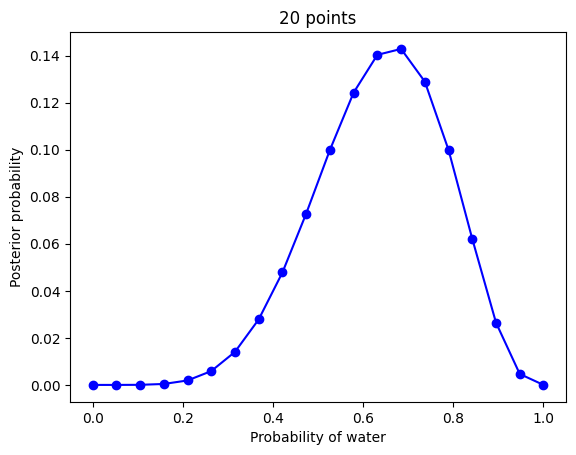

In [78]:
plt.plot(p_grid, posterior, 'bo-')
plt.title(f"{GRID_POINTS} points")
plt.xlabel('Probability of water')
plt.ylabel('Posterior probability')
plt.show()

### Code 2.5

Replace with different priors.

In [29]:
prior = np.where(p_grid < 0.5, 0, 1)
prior = np.e**(-5 * abs(p_grid - 0.5))

### Code 2.6

Compute the quadratic approximation.

1. Find the posterior mode. This is usually achieved by some optimization algorithm, a procedure that virtually "climbs" the posterior distribution, as if it were a mountain.
2. Once you find the peak of the posterior, you must estimate the curvature near the peak.

In [37]:
data = np.repeat((0, 1), (3, 6))
with pm.Model() as normal_approximation:
    p = pm.Uniform("p", 0, 1)  # uniform priors
    w = pm.Binomial("w", n=len(data), p=p, observed=data.sum())  # binomial likelihood
    mean_q = pm.find_MAP()

    p_value = normal_approximation.rvs_to_values[p]
    p_value.tag.transform = None
    p_value.name = p.name

    std_q = ((1 / pm.find_hessian(mean_q, vars=[p])) ** 0.5)[0]

# display summary of quadratic approximation
print("\tMean\tStandard deviation\np \t{:.2}\t{:.2}".format(mean_q["p"], std_q[0]))


	Mean	Standard deviation
p 	0.67	0.16


In [39]:
# Compute the 89% percentile interval
norm = stats.norm(mean_q, std_q)
prob = 0.89
z = stats.norm.ppf([(1 - prob) / 2, (1 + prob) / 2])
pi = mean_q["p"] + std_q * z
print("\t5.5%\t94.5% \n\t{:.2}\t{:.2}".format(pi[0], pi[1]))

	5.5%	94.5% 
	0.42	0.92


### Code 2.7

Comparare how good the approximation is. Beta is the analytical approach to the problem.

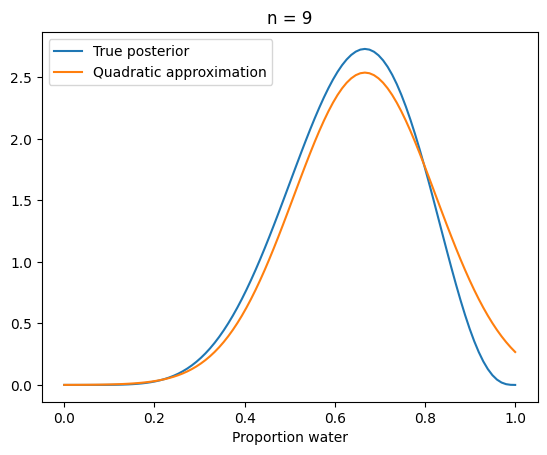

In [43]:
# Analytical calculation.
W = 6
L = 3

x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), label="True posterior")

# Quadratic approximation.
plt.plot(x, stats.norm.pdf(x, mean_q["p"], std_q), label="Quadratic approximation")
plt.legend(loc=0)

plt.title(f"n = {W+L}")
plt.xlabel("Proportion water");

### Code 2.8

Applying the Markot Chain Monte Carlo (MCMC) to solve the globe tossing problem.

In [73]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W, L = 6, 3
for i in range(1, n_samples):
    p_new = stats.norm(p[i - 1], 0.1).rvs(1)
    if p_new < 0:
        p_new = abs(p_new)
    if p_new > 1:
        p_new = 2 - p_new
    q0 = stats.binom.pmf(W, n=W+L, p=p[i-1])
    q1 = stats.binom.pmf(W, n=W+L, p=p_new)
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

### Code 2.9

Compare with the analytical posterior.

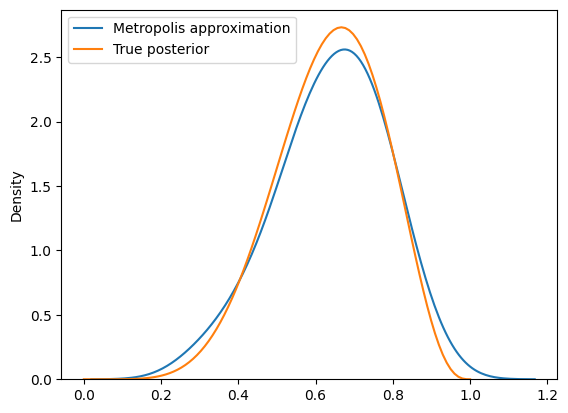

In [76]:
sns.kdeplot(p, bw_method=0.5, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x, W + 1, L + 1), "C1", label="True posterior")
plt.legend();